In [2]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio
import librosa
import IPython.display as ipd

In [3]:
print(tf.__version__)

2.10.1


In [4]:
CAPUCHIN_FILE = os.path.join('Data','audio_dataset', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('Data','audio_dataset', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [5]:
ipd.Audio(CAPUCHIN_FILE)

In [6]:
ipd.Audio(NOT_CAPUCHIN_FILE)

In [7]:
POS = os.path.join('Data/audio_dataset/Parsed_Capuchinbird_Clips')
NEG = os.path.join('Data/audio_dataset/Parsed_Not_Capuchinbird_Clips')

In [8]:
def load_aud_librosa(filename):
    try:
        wave, sample_rate = librosa.load(filename, sr=16000)
        return wave
    except Exception as e:
        print(f"Error loading audio file {filename} with librosa: {e}")
        return None

In [9]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [10]:
positives = tf.data.Dataset.zip((pos,tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg,tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))

In [11]:
data= positives.concatenate(negatives)

In [12]:
len(data)

810

In [13]:
lengths_librosa = []
for file in os.listdir(os.path.join('Data/audio_dataset/Parsed_Capuchinbird_Clips')):
    tensor_wave_librosa = load_aud_librosa(os.path.join('Data/audio_dataset/Parsed_Capuchinbird_Clips', file))
    if tensor_wave_librosa is not None:
        lengths_librosa.append(len(tensor_wave_librosa))
    else:
        # Handle the case where there was an error loading the audio file
        print(f"Skipping file: {file}")


In [14]:
print('Average length of the call:',tf.math.reduce_mean(lengths_librosa))
print('Min length of the call:',tf.math.reduce_min(lengths_librosa))
print('Max length of the call:',tf.math.reduce_max(lengths_librosa))

Average length of the call: tf.Tensor(54156, shape=(), dtype=int32)
Min length of the call: tf.Tensor(32000, shape=(), dtype=int32)
Max length of the call: tf.Tensor(80000, shape=(), dtype=int32)


In [15]:
def spectro(file_path,label):
    wave = load_aud_librosa(file_path)
    wave =  wave[:48000]
    zero_padding = tf.zeros([48000]-tf.shape(wave),dtype=tf.float32)
    wave = tf.concat([zero_padding,wave],0)
    spectrogram = tf.signal.stft(wave, frame_length=320 , frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram,axis=2)
    return spectrogram,label

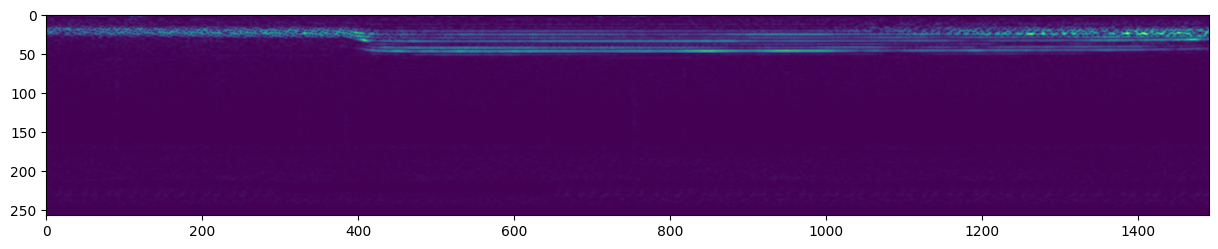

In [16]:
filepath,label = positives.shuffle(1000).as_numpy_iterator().next()

spectrogram,label = spectro(filepath,label)

plt.figure(figsize=(15,10))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

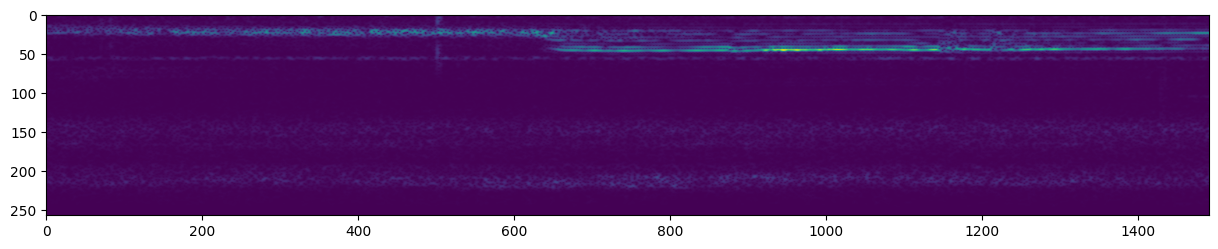

In [17]:
filepath,label = positives.shuffle(1000).as_numpy_iterator().next()

spectrogram,label = spectro(filepath,label)

plt.figure(figsize=(15,10))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()